# Credit Limit Assessment (CLA)

In [1]:
#!pip install autokeras

In [2]:
import tensorflow as tf
keras = tf.keras
import os
import random
from random import randrange
from datetime import datetime
from datetime import timedelta
# Работа с массивами данных
import numpy as np 
# Работа с табличными данными
import pandas as pd
# Отрисовка графиков
import matplotlib.pyplot as plt
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler
import joblib

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

#from tensorflow.keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint 

from tensorflow.keras.models import model_from_json

#from autokeras import StructuredDataRegressor
import autokeras as ak

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print (type(gpus), f'gpus ={gpus}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print (type(gpu), f'gpu ={gpu}')

<class 'list'> gpus =[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<class 'tensorflow.python.eager.context.PhysicalDevice'> gpu =PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data Simulation Functions

In [4]:
def DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES):
  NUMBER_LINES = int (NUMBER_LINES)
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 1000
  else:
    max = 100

  if CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile UAE':
    min = max // 2
  elif CUSTOMER_SUB_SEGMENT == 'Mobile UAE':
    min = max // 3
  elif CUSTOMER_SUB_SEGMENT == 'Fixed UAE':
    min = max // 4
  elif CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile Expat':
    min = max // 5 
  else:
    min = 0
  cl = random.randint(min, max) + NUMBER_LINES * 10
  return str(cl)


In [5]:
def DS_NUMBER_LINES(CUSTOMER_TYPE):
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 300
  else:
    max = 10
  min = 0
  n_lines = random.randint(min, max)
  return str(n_lines)  


In [6]:
def DS_CUSTOMER_TYPE():
  DS_LIST = ['Residential Customer Account', 'Business Customer Account']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_TYPE()

In [7]:
def DS_CUSTOMER_SUB_SEGMENT():
  DS_LIST = ['Fixed & Mobile Expat', 'Mobile Expat', 'Fixed Expat', 'Fixed & Mobile UAE', 'Mobile UAE', 'Fixed UAE']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_SUB_SEGMENT()

In [8]:
def head_line():
  return 'NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT,ACTIVATED_CL'

In [9]:
def df_lines(num_lines):
  myfile = open('CLA_001.csv', 'w')
  df_str = '' + head_line() + '\n'
  myfile.writelines(df_str)
  for _ in range(num_lines):
    CUSTOMER_TYPE = DS_CUSTOMER_TYPE()
    CUSTOMER_SUB_SEGMENT = DS_CUSTOMER_SUB_SEGMENT()
    NUMBER_LINES = DS_NUMBER_LINES(CUSTOMER_TYPE)
    ACTIVATED_CL = DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES)

    df_str = '' + NUMBER_LINES \
      + ',' + CUSTOMER_TYPE \
      + ',' + CUSTOMER_SUB_SEGMENT \
      + ',' + ACTIVATED_CL \
      + '\n'
    myfile.writelines(df_str)
  myfile.close()

## DF Simulation

In [10]:
# df_str = df_lines(300000)
df_str = df_lines(1000)

## DF

In [11]:
df = pd.read_csv('CLA_001.csv')# Это то, куда вы скачали файл
# Количество и критерии
print(df.shape)

(1000, 4)


In [12]:
df.head()

,NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT,ACTIVATED_CL
0,4,Residential Customer Account,Mobile Expat,58
1,3,Residential Customer Account,Fixed & Mobile UAE,98
2,217,Business Customer Account,Fixed & Mobile Expat,3026
3,153,Business Customer Account,Fixed Expat,2207
4,236,Business Customer Account,Mobile UAE,2965


In [13]:
print(df.columns) #Показываем имена колонок данных

Index(['NUMBER_LINES', 'CUSTOMER_TYPE', 'CUSTOMER_SUB_SEGMENT',
       'ACTIVATED_CL'],
      dtype='object')


In [14]:
df.dtypes

NUMBER_LINES             int64
CUSTOMER_TYPE           object
CUSTOMER_SUB_SEGMENT    object
ACTIVATED_CL             int64
dtype: object

In [15]:
# max value in NUMBER_LINES
MAX_NUMBER_LINES = df['NUMBER_LINES'].max()
print(f'MAX_NUMBER_LINES={MAX_NUMBER_LINES}')

MAX_NUMBER_LINES=300


## Преобразование DF

In [16]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_NUMBER_LINES         = df.columns.get_loc('NUMBER_LINES')
COL_CUSTOMER_TYPE        = df.columns.get_loc('CUSTOMER_TYPE')
COL_CUSTOMER_SUB_SEGMENT = df.columns.get_loc('CUSTOMER_SUB_SEGMENT')
COL_ACTIVATED_CL         = df.columns.get_loc('ACTIVATED_CL')

In [17]:
# Классы CUSTOMER_TYPE
CUSTOMER_TYPE_class = [0, 
                    {'Business Customer Account	'   : 0,
                     'Residential Customer Account' : 1
                    }]
# Классы CUSTOMER_SUB_SEGMENT
CUSTOMER_SUB_SEGMENT_class = [0, 
              {'Fixed & Mobile Expat' : 0,
               'Mobile Expat'         : 1,
               'Fixed Expat'          : 2,
               'Fixed & Mobile UAE'   : 3,
               'Mobile UAE'           : 4,
               'Fixed UAE'            : 5
                             }]

In [18]:
# Вычисление счетчиков для данных разбиения
for class_desc in [CUSTOMER_TYPE_class,
                   CUSTOMER_SUB_SEGMENT_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [19]:
CUSTOMER_SUB_SEGMENT_class

[6,
 {'Fixed & Mobile Expat': 0,
  'Mobile Expat': 1,
  'Fixed Expat': 2,
  'Fixed & Mobile UAE': 3,
  'Mobile UAE': 4,
  'Fixed UAE': 5}]

In [20]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
      # print(f'value={value} cls={cls}')
      if value == arg:
          result[cls] = 1.

    return result

def extract_CUSTOMER_SUB_SEGMENT_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_SUB_SEGMENT_class)

def extract_CUSTOMER_TYPE_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_TYPE_class)

In [21]:
CUSTOMER_SS = 'Fixed & Mobile UAE'
extract_CUSTOMER_SUB_SEGMENT_to_multi(CUSTOMER_SS)

array([0., 0., 0., 1., 0., 0.])

In [22]:
CUSTOMER_TYPE = 'Residential Customer Account'
extract_CUSTOMER_TYPE_to_multi(CUSTOMER_TYPE)

array([0., 1.])

In [23]:
def extract_NUMBER_LINES_Category(arg, MAX_NUMBER_LINES):
  NUMBER_LINES = utils.to_categorical(arg, MAX_NUMBER_LINES+1) #Превращаем в категорию
  return NUMBER_LINES

In [24]:
# Привмер вызова 
extract_NUMBER_LINES_Category(100,MAX_NUMBER_LINES)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
def extract_row_data(row):
  ACTIVATED_CL = int(row[COL_ACTIVATED_CL])
  ACTIVATED_CL_vec = np.array([ACTIVATED_CL])

  NUMBER_LINES = int(row[COL_NUMBER_LINES])
  # NUMBER_LINES_vec = np.array([NUMBER_LINES])
  NUMBER_LINES_vec = extract_NUMBER_LINES_Category(NUMBER_LINES, MAX_NUMBER_LINES)
  
  CUSTOMER_TYPE_ohe = extract_CUSTOMER_TYPE_to_multi(row[COL_CUSTOMER_TYPE])
  CUSTOMER_SUB_SEGMENT_ohe = extract_CUSTOMER_SUB_SEGMENT_to_multi(row[COL_CUSTOMER_SUB_SEGMENT])

  # Объединение всех входных данных в один общий вектор
  x_data = np.hstack([NUMBER_LINES_vec, 
                      CUSTOMER_TYPE_ohe,
                      CUSTOMER_SUB_SEGMENT_ohe])
    
  # Возврат входных данных и выходных (зарплаты)
  return x_data, ACTIVATED_CL_vec

  # Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)


In [26]:
# Формирование выборки из загруженного набора данных    
x_train, y_train = construct_train_data(df.values)

In [27]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaler = y_scaler.fit_transform(y_train)

In [28]:
joblib.dump(y_scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [29]:
# Проверка нормализации
print(y_train.shape)
print(f'Оригинальное значение CL:  {y_train [1, 0]}')
print(f'Нормированное значение CL: {y_train_scaler [1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train_scaler.mean(), y_train_scaler.std())
print(y_train.mean(), y_train.std())

(1000, 1)
Оригинальное значение CL:  98
Нормированное значение CL: -0.8404241550985481
-2.842170943040401e-17 1.0
1114.903 1209.9878303483056


In [30]:
# Далее используем только нормализовннаые данные
y_train = y_train_scaler 
# В итоге мы получаем следующие наборы данных:
print(x_train.shape) 
print(y_train.shape)
print(type(x_train), type(y_train))

# Пример обработанных данных
n = 0 
print(x_train[n])
print(y_train[n])

(1000, 309)
(1000, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

## AutoML

In [31]:
search = ak.StructuredDataRegressor(max_trials=50, loss='mean_absolute_error')

In [32]:
search.fit(x=x_train, y=y_train)

Trial 50 Complete [00h 00m 50s]

Best val_loss So Far: 0.3299561142921448
Total elapsed time: 02h 56m 31s
INFO:tensorflow:Oracle triggered exit
Epoch 1/32
32/32 [==============================] - 8s 70ms/step - loss: 2.9443 - mean_squared_error: 32.8602
Epoch 2/32
32/32 [==============================] - 2s 70ms/step - loss: 0.8432 - mean_squared_error: 1.2784
Epoch 3/32
32/32 [==============================] - 2s 70ms/step - loss: 0.8322 - mean_squared_error: 1.3382
Epoch 4/32
32/32 [==============================] - 2s 70ms/step - loss: 0.8129 - mean_squared_error: 1.3062
Epoch 5/32
32/32 [==============================] - 2s 69ms/step - loss: 0.8115 - mean_squared_error: 1.2299
Epoch 6/32
32/32 [==============================] - 2s 71ms/step - loss: 0.7517 - mean_squared_error: 0.9969
Epoch 7/32
32/32 [==============================] - 2s 70ms/step - loss: 0.7660 - mean_squared_error: 1.0020
Epoch 8/32
32/32 [==============================] - 2s 71ms/step - loss: 0.6845 - mean_squar

In [33]:
train_mae, _ = search.evaluate(x_train, y_train, verbose=0)
print('Mean Absolute Error is {}'.format(train_mae))

Mean Absolute Error is 0.39763885736465454


In [34]:
test_mae, _ = search.evaluate(x_train, y_train, verbose=0)
print('Mean Absolute Error is {}'.format(test_mae))

Mean Absolute Error is 0.39763885736465454


In [35]:
# чтобы получить num_models лучших моделей:
best_models = search.tuner.get_best_models(num_models=3)

In [36]:
def show_best_model(best_model):
  best_model.summary()
  utils.plot_model(best_model, show_shapes=True)
  img = plt.imread('model.png')
  plt.figure(figsize = (10,10))
  plt.imshow(img)
  plt.axis('off')


In [37]:
# show_best_model(best_models[0])

In [38]:
# show_best_model(best_models[1])

In [39]:
# show_best_model(best_models[2])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 309)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 309)              0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 512)               158720    
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                             

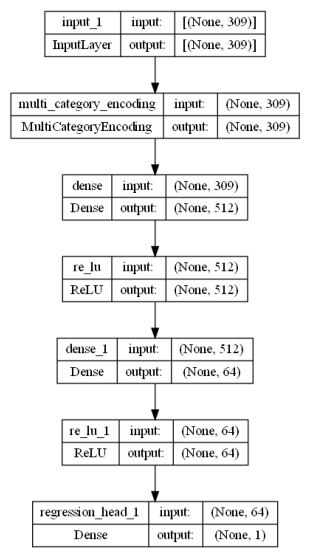

In [40]:
# get the best model
model = search.export_model()
show_best_model(model)

In [41]:
# Сохраняем саму модель
# Сериализация в JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# Сохраняем(сериализуем) веса  в формате HDF5
# model.save_weights("/content/model.h5")
print("Сохранено")


Сохранено


In [42]:
# model.save("model_cla_005.h5", save_format="h5")

In [43]:
# Открываем json файл разметки модели
json_file = open('model.json','r') 
loaded_model_json = json_file.read() # считываем
json_file.close() # закрываем
model = model_from_json(loaded_model_json) # используем керас, чтобы считать разметку архитектуры
model.summary()
# loaded_model.load_weights("/content/model.h5") # подгружаем веса
print("Загружено с диска")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 309)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 309)              0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 512)               158720    
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                             

In [44]:
# model.save('model_sonar.h5')

In [45]:
# https://github.com/keras-team/autokeras/issues/1081
# def load_pickle_model_from_file(name_file):
#     with open(name_file, 'rb') as file:
#         loaded_model = pickle.load(file)
#     return loaded_model

# def save_pickle_model_to_file(model, name_model):
#     with open(Path(str(name_model)+".pickle"), 'wb') as file:
#         pickle.dump(model, file)
#     print(str(Path(str(name_model)+".pickle"))+' - model saved!')

In [46]:
# save_pickle_model_to_file(model, '/content/model_CLA_005')